In [1]:
import langid
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer

WORDBAGS_JSON = 'data/WordbagsBuckets.json'

# Site clustering

While importing the data we should divide it into english and polish cathegories, thus why we again utilise the langid library and create _pl and _en corpuses.

We use TfidVectorizer with idf option which corresponds to TF-IDF featre weighting, and sublinear_tf flag allows us to smooth the weights, making the difference between 20 and 22 occurences of a word less important than 0 and 2. We limit it to include only words that make less than 50% of documents and appear at least twice.

In order to achieve the goal of clustering the sites we have to decide on the clustering alghoritm. I choose to stick to the well known KMeans clsutering, as it is simple, general-purpose tool suited well for a small number of classes. Additionally we don't need the feature of dynamically choosing that number, a feature offered by few other alghoritms like OPTICS. 

It would be benefitial to perform a singular value decomposition on our feature matrix before stuffing it into KMeans alghoritm, as it improves its performance for high-dimensional data like ours, with over 10000 word-features for only 27 sites. We could normalise them, but the work of reweighting the veactors' features has been already done by sublinear_tf flag. 

We display the results minding the decomposition we made earlier has to be rolled back.

In [22]:
df = pd.read_json(WORDBAGS_JSON)
df = df[df['wordbag'] != ''].copy()
df['pl'] = [False if (langid.classify(' '.join(df.iloc[i]['wordbag'].split()[:50]))[0] == 'en') else True
             for i in range(0, len(df.values))]

corpus_pl = [row.wordbag for _,row in df[df['pl']].iterrows()]
sites_pl = df[df['pl']]['netloc'].values

corpus_en = [row.wordbag for _,row in df[~df['pl']].iterrows()]
sites_en = df[~df['pl']]['netloc'].values

In [35]:
#np.random.seed(2137)
n_clusters = 4

vectorizer_pl = TfidfVectorizer(sublinear_tf=True, max_pl_df=0.4, min_df=2, use_idf=True)
X_pl = vectorizer_pl.fit_transform(corpus_pl)

vectorizer_en = TfidfVectorizer(sublinear_tf=True, max_pl_df=0.4, min_df=2, use_idf=True)
X_en = vectorizer_en.fit_transform(corpus_en)

In [36]:
svd_pl = TruncatedSVD(100)
X_pl = svd_pl.fit_transform(X_pl)

svd_en = TruncatedSVD(100)
X_en = svd_en.fit_transform(X_en)

In [48]:
km_pl = KMeans(
        n_clusters=n_clusters,
        init="k-means++",
        max_pl_iter=100,
        n_init=10
)
print('Clustering pl ')
t0 = time.time()
km_pl.fit(X_pl)
print(f'done in {time.time() - t0}' )

print(km_pl.labels_)
terms_pl = vectorizer_pl.get_feature_names_out()
original_space_centroids_pl = svd_pl.inverse_transform(km_pl.cluster_centers_)
order_centroids_pl = original_space_centroids_pl.argsort()[:, ::-1]


km_en = KMeans(
        n_clusters=n_clusters,
        init="k-means++",
        max_pl_iter=100,
        n_init=10
)
print('Clustering en ')
t0 = time.time()
km_en.fit(X_en)
print(f'done in {time.time() - t0}' )

print(km_en.labels_)
terms_en = vectorizer_en.get_feature_names_out()
original_space_centroids_en = svd_en.inverse_transform(km_en.cluster_centers_)
order_centroids_en = original_space_centroids_en.argsort()[:, ::-1]

Clustering pl 
done in 0.06147265434265137
[2 2 0 2 2 0 2 0 0 0 2 1 3 1 2 2 0 2 0 2 3 1 0 2 2 2 0]
Clustering en 
done in 0.08124756813049316
[2 2 1 2 2 2 2 2 2 2 0 3 3 3]


## Effects

Below written are the effects of clustering on _pl and _en categorised websites along with 10 most significant word for each class.

Repeated tests proved, that limiting oneself to 2 groups - presumeably the "laisure" and "work" kinds of sites - makes the predictions less accurate than our intuition would suggest. 
Fortunately, the third one groups only the outlook domain, which itself fits to neither of those two.

In [51]:
for i in range(n_clusters):
    print(f'Cluster {i} ', end='')
    print({sites_pl[l] for l in range(len(sites_pl)) if km_pl.labels_[l] == i}, end=':\n ')
    for k in order_centroids_pl[i, :10]:
        print(f' {terms_pl[k]} ', end='')
    print()

Cluster 0 {'www.instagram.com', 'www.cloudskillsboost.google', 'pandas.pydata.org', 'nofluffjobs.com', 'coub.com', 'translate.google.pl', 'soundcloud.com', 'www.sokmarket.com.tr', 'www.facebook.com'}:
  cooki  için  adr  size  daha  spersonalizować  plików  wykorzystywać  personalizacja  dostarczać 
Cluster 1 {'drive.google.com', 'app.erasmusplusols.eu', 'accounts.google.com'}:
  latviešu  magyar  eesti  ελληνικά  hrvatski  български  slovenčina  slovenščina  čeština  română 
Cluster 2 {'sjp.pl', 'www.youtube.com', 'synonim.net', 'im.uj.edu.pl', 'pl.wikipedia.org', 'sjp.pwn.pl', 'api.stat.gov.pl', 'stat.gov.pl', 'login.uj.edu.pl', 'docs.google.com', 'www.usosweb.uj.edu.pl', 'bdl.stat.gov.pl', 'www.linkedin.com'}:
  urząd  wzgląd  zablokować  prosić  słowo  naukowy  jagielloński  student  studia  uniwersytet 
Cluster 3 {'outlook.office365.com', 'outlook.office.com'}:
  ponownie  spróbować  warunki  base  odświeżyć  error  wystąpić  date  access  absolutny 


In [50]:
for i in range(n_clusters):
    print(f'Cluster {i} ', end='')
    print({sites_en[l] for l in range(len(sites_en)) if km_en.labels_[l] == i}, end=':\n ')
    for k in order_centroids_en[i, :10]:
        print(f' {terms_en[k]} ', end='')
    print()

Cluster 0 {'odtuclass2021f.metu.edu.tr'}:
  athttp  semest  archiv  cooper  aaron  aandb  abandon  abcdefghij  courtesi  latch 
Cluster 1 {'www.overleaf.com'}:
  overleaf  beamer  feder  universidad  theme  institut  universiteit  serviceappli  universität  usepackag 
Cluster 2 {'www.kaggle.com', 'github.com', 'www.geeksforgeeks.org', 'www.w3schools.com', 'math.stackexchange.com', 'stackoverflow.com', 'en.wikipedia.org', 'www.reddit.com', 'www.postgresql.org'}:
  ourterm  schema  kaggl  danych  entiti  motion  copyright  kumar  dark  dane 
Cluster 3 {'www.roblox.com', 'www.gradescope.com', 'www.coursera.org'}:
  grade  courtesi  texttt  republ  illinoi  fring  instructor  island  consent  invest 


## Averaging
The outcome is often not identical for each execution, so in order to obtain a statistical image we'll average out several executions of clustering before writing down the classification. The outcome of it will be a family set of sets (each iteration produces 8 sets separating each corpus to 4 disjoint sets), so we'll calculate the ratios of "sharing the same group" between sites, which can be bautifully expressed via a 2d heatmap.

In [88]:
def ratioing(a, b, the_list):
    count = 0
    for x in the_list:
        if a in x and b in x:
            count += 1
    return (count*n_clusters)/len(the_list)

In [89]:
n_clusters = 4
iters = 100

vectorizer_pl = TfidfVectorizer(sublinear_tf=True, max_pl_df=0.4, min_df=2, use_idf=True)
X_pl = vectorizer_pl.fit_transform(corpus_pl)
vectorizer_en = TfidfVectorizer(sublinear_tf=True, max_pl_df=0.4, min_df=2, use_idf=True)
X_en = vectorizer_en.fit_transform(corpus_en)

svd_pl = TruncatedSVD(100)
X_pl = svd_pl.fit_transform(X_pl)
svd_en = TruncatedSVD(100)
X_en = svd_en.fit_transform(X_en) 

list_pl = []
list_en = []

for i in range(iters):
    km_pl = KMeans(
            n_clusters=n_clusters,
            init="k-means++",
            max_pl_iter=100,
            n_init=10
    )
    km_pl.fit(X_pl)

    km_en = KMeans(
            n_clusters=n_clusters,
            init="k-means++",
            max_pl_iter=100,
            n_init=10
    )
    km_en.fit(X_en)

    for k in range(n_clusters):
        set_pl = {l for l in range(len(sites_pl)) if km_pl.labels_[l] == k}
        list_pl.append(set_pl)
        
        set_en = {l for l in range(len(sites_en)) if km_en.labels_[l] == k}
        list_en.append(set_en)

ratios_pl = [[ratioing(k, l, list_pl) for l in range(len(sites_pl))] for k in range(len(sites_pl))]
ratios_en = [[ratioing(k, l, list_en) for l in range(len(sites_en))] for k in range(len(sites_en))]

## Visualisation

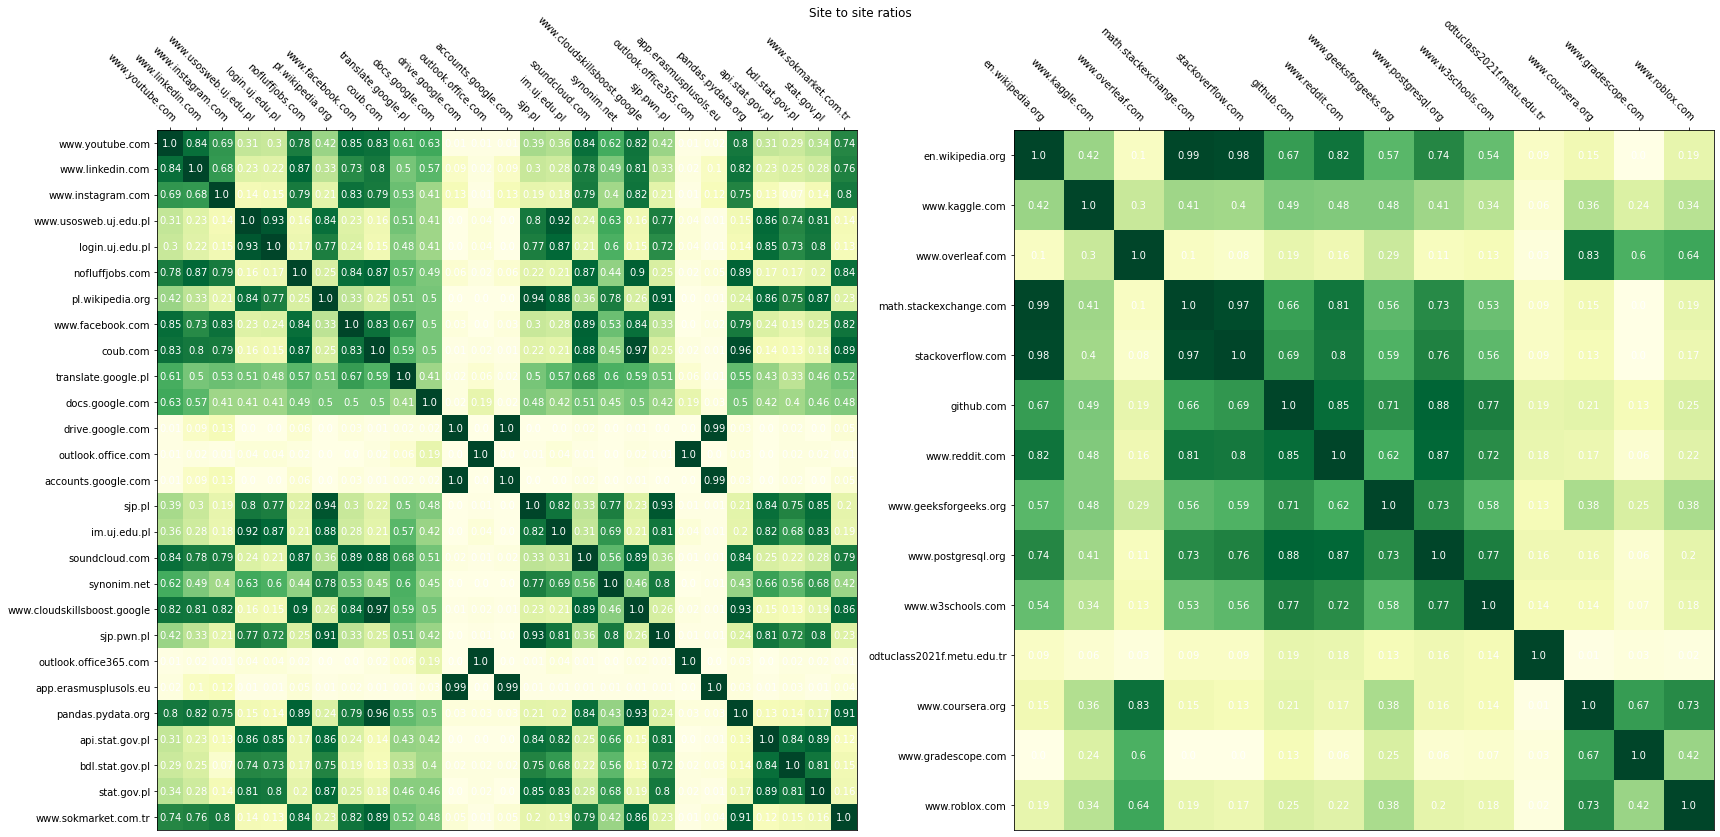

In [110]:
fig, (ax_pl, ax_en) = plt.subplots(1,2, figsize =(24, 12))
im_pl = ax_pl.imshow(ratios_pl, cmap = 'YlGn')

ax_pl.set_xticks(np.arange(len(ratios_pl)), labels = sites_pl)
ax_pl.set_yticks(np.arange(len(ratios_pl)), labels = sites_pl)

ax_pl.tick_params(top=True, bottom=False,
               labeltop=True, labelbottom=False)
plt.setp(ax_pl.get_xticklabels(), rotation=-45, ha='right', rotation_mode='anchor')

    
for i in range(len(ratios_pl)):
    for j in range(len(ratios_pl)):
        text_pl = ax_pl.text(j, i, ratios_pl[i][j], ha='center', va='center', color='w')
        
        
im_en = ax_en.imshow(ratios_en, cmap = 'YlGn')

ax_en.set_xticks(np.arange(len(ratios_en)), labels = sites_en)
ax_en.set_yticks(np.arange(len(ratios_en)), labels = sites_en)

ax_en.tick_params(top=True, bottom=False,
               labeltop=True, labelbottom=False)
plt.setp(ax_en.get_xticklabels(), rotation=-45, ha='right', rotation_mode='anchor')

    
for i in range(len(ratios_en)):
    for j in range(len(ratios_en)):
        text_en = ax_en.text(j, i, ratios_en[i][j], ha='center', va='center', color='w')        
        
fig.suptitle('Site to site ratios')
fig.tight_layout()
plt.show()


## Final classification

We can point out several groupings, among which not all are intuitional and serve our purpose. For example, somehow the erasmusplusOLS site has almost perfect correlation with accounts.google.com.

We will decide on grouping by selecting one from all of the groupings done so far, judging by how much it fits our correlation-like matrices. The method of judgement will be simple: for each set in each grouping we calculate a sum of ratios between each pair within it. Consider this dummy example on two sets:

A = {sjp.pwn.pl, sjp.pl, synonim.net} and B = {sjp.pwn.pl, bdl.stat.gov.pl, synonim.net}. We can read following correlations: 
- sjp.pwn.pl - sjp.pl: 0.93
- sjp.pl - synonim.net: 0.77
- sjp.pwn.pl - synonim.net: 0.8
- sjp.pwn.pl - bdl.stat.gov.pl: 0.72
- bdl.stat.gov.pl - synonim.net: 0.66

The scores for A and B are accordingly 0.93 + 0.77 + 0.8 = 2.5 and 0.8 + 0.72 + 0.66 = 2.18

With our metric, the A fits the _pl matrix better than B. We later sum all the scores for each groupings to compare whole groupings.